# Machine Learning for classifying SARS-CoV-2 data

## Overview 
SARS-Cov-2 MPro is one of the most studied enzymes for the development of an effective treatment against COVID-19. 
It has an active role on the viral replication, for being catalyst of the virus' polyprotein in functional proteins (Anand et al. 2002). Therefore, application of virtual screening (VS) allied to molecular docking appears as an option for the search of a pharmacore candidate which can modulate MPro activity, reducing the viral load (Chen, Yiu, and Wong 2020).     

This notebook is the result of an application of SBVS, molecular descriptors and machine learning techniques for identifying active and inactive compounds given an SARS-CoV-2 assay. [PostEra.ai](https://covid.postera.ai/covid/activity_data)'s bioassay is the main set, which RapidFire and fluorescence data are used for dividing and labeling the train and test sets' compounds into active and inactive. The constructed models are then assessed as to their ability to classify active and inactive coumpounds given a number of descriptors.

## References
Anand K et al. Structure of coronavirus main proteinase reveals combination of a chymotrypsin fold with an extra alpha-helical domain. EMBO J. 2002 Jul 1;21(13):3213-24.    

Chen YW et al. Prediction of the SARS-CoV-2 (2019-nCoV) 3C-like protease (3CL pro) structure: virtual screening reveals velpatasvir, ledipasvir, and other drug repurposing candidates. F1000Res. 2020 Feb 21;9:129.    

## Table of contents

1. [Reading data](#reading_data)
2. [Machine learning](#machine_learning)    
    a. [Evaluation metrics](#evaluation_metrics)    
    b. [Constructing the models](#constructing_models)    
3. [Performace analysis](#performance_analysis)     
    a. [Comparing different models and rescaling methods](#comparing)    
    b. [Finding the best subset](#finding)     
    c. [ROC curves](#roc_curves)

<a id='reading_data'></a>
## Reading data

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np

In [2]:
# Read QuickVina02 results
qvina         = pd.read_csv('qvina.csv')
qvina.columns = ['CID','pose','qvina']

# Read QVina rescored with RF-Score
rfscore_qvina         = pd.read_csv('rfscore_qvina.csv')
rfscore_qvina.columns = ['CID','pose','rfscore_qvina']

# Top QVina poses
top_qvina  = pd.merge(qvina.query('pose == 1'), rfscore_qvina.query('pose == 1'))
top_qvina.drop('pose', axis=1, inplace=True)
top_qvina.head()

,CID,qvina,rfscore_qvina
0,MAR-UNI-c84db004-13,-9.0,6.586498
1,BAR-COM-4e090d3a-53,-7.5,7.221692
2,TRY-UNI-714a760b-6,-6.4,6.377253
3,EDJ-MED-c9f55a56-1,-6.2,5.491030
4,LON-WEI-0a73fcb8-7,-7.4,6.677942


In [3]:
# Read PLANTS results
plants         = pd.read_csv('plants.csv')
plants.columns = ['CID','pose','plants']

# Read PLANTS rescored with RF-Score
rfscore_plants         = pd.read_csv('rfscore_plants.csv', header=None)
rfscore_plants.columns = ['rfscore_plants','CID']
rfscore_plants         = rfscore_plants[['CID','rfscore_plants']]
rfscore_plants[['CID','pose']] = rfscore_plants['CID'].str.split('_', expand=True)
rfscore_plants['pose']         = rfscore_plants['pose'].astype('int')

# Top PLANTS poses
top_plants = pd.merge(plants.query('pose == 1'), rfscore_plants.query('pose == 1'))
top_plants.drop('pose', axis=1, inplace=True)
top_plants.head()

,CID,plants,rfscore_plants
0,EDG-MED-0da5ad92-3,-70.8540,6.885798
1,DAR-DIA-23aa0b97-19,-79.4982,6.852397
2,MAT-POS-590ac91e-22,-70.4662,6.217164
3,LON-WEI-1908424e-3,-90.5268,7.534084
4,GIA-UNK-30c7cb75-1,-76.6202,6.839672


In [4]:
# Read experimental data
experimental = pd.read_csv('activity_data.csv')
experimental.head()

,SMILES,CID,canonical_CID,r_inhibition_at_20_uM,r_inhibition_at_50_uM,r_avg_IC50,f_inhibition_at_20_uM,f_inhibition_at_50_uM,f_avg_IC50,f_avg_pIC50,relative_solubility_at_20_uM,relative_solubility_at_100_uM,trypsin_IC50,NMR_std_ratio,acrylamide,chloroacetamide,series
0,COC(=O)C(C(=O)Nc1cnccc1C)c1cccc(Cl)c1,MAT-POS-1e5f28a7-1,MAT-POS-1e5f28a7-1,NaN,NaN,17.091397,NaN,NaN,23.712295,4.625026,NaN,NaN,NaN,NaN,False,False,3-aminopyridine-like
1,OCCn1c(CSc2nc3ccccc3o2)nc2ccc(Cl)cc21,MAT-POS-e10a589d-1,MAT-POS-e10a589d-1,NaN,NaN,99.000000,NaN,NaN,0.326703,6.485847,NaN,NaN,NaN,NaN,False,False,NaN
2,N#Cc1ncn(CC(=O)Nc2ccc(Br)cc2Cl)n1,MAT-POS-e10a589d-4,MAT-POS-e10a589d-4,NaN,NaN,NaN,NaN,NaN,15.730897,4.803247,NaN,NaN,NaN,NaN,False,False,3-aminopyridine-like
3,Cn1nc(-c2ccc(C(F)(F)F)cc2)nc2c(=O)n(C)c(=O)nc1-2,MAT-POS-1e0c1c67-1,MAT-POS-1e0c1c67-1,NaN,NaN,99.000000,NaN,NaN,2.400602,5.619680,NaN,NaN,NaN,NaN,False,False,NaN
4,Cc1cc2c(cc1C)C(C(=O)N1CCCCC1c1cn[nH]c1)CO2,MAT-POS-6da3605a-1,MAT-POS-6da3605a-1,NaN,NaN,99.000000,NaN,NaN,99.500000,NaN,NaN,NaN,NaN,NaN,False,False,NaN


/home/caio/miniconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


,r_inhibition_at_50_uM,f_inhibition_at_50_uM
r_inhibition_at_50_uM,1.00000,0.69973
f_inhibition_at_50_uM,0.69973,1.00000


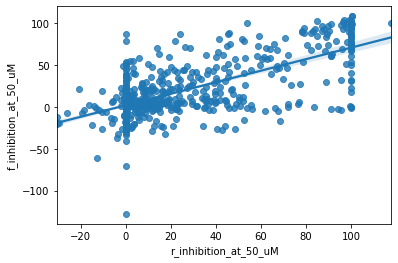

In [5]:
# Correlation between "RapidFire" assay and fluorescence assay
sns.regplot(experimental['r_inhibition_at_50_uM'], experimental['f_inhibition_at_50_uM'])
experimental[['r_inhibition_at_50_uM','f_inhibition_at_50_uM']].corr()

In [6]:
# Merge top scores and experimental data
tmp = pd.merge(top_qvina, top_plants)
top = pd.merge(tmp, experimental[['CID','r_inhibition_at_50_uM','r_avg_IC50','f_inhibition_at_50_uM','f_avg_IC50']])
del tmp

# _Normalize_ scores
#top['plants'] /= 10
#top[['rfscore_qvina','rfscore_plants']] *= -1

top

,CID,qvina,rfscore_qvina,plants,rfscore_plants,r_inhibition_at_50_uM,r_avg_IC50,f_inhibition_at_50_uM,f_avg_IC50
0,MAR-UNI-c84db004-13,-9.0,6.586498,-85.9230,7.447876,0.000000,NaN,NaN,NaN
1,BAR-COM-4e090d3a-53,-7.5,7.221692,-83.8857,7.340981,0.000000,NaN,16.960570,NaN
2,TRY-UNI-714a760b-6,-6.4,6.377253,-68.7197,6.414523,NaN,13.895165,81.756960,24.566619
3,EDJ-MED-c9f55a56-1,-6.2,5.491030,-69.4555,6.042434,4.870901,NaN,0.403773,NaN
4,LON-WEI-0a73fcb8-7,-7.4,6.677942,-73.4504,6.826287,58.930356,66.350807,84.229060,13.671987
...,...,...,...,...,...,...,...,...,...
938,MED-COV-4280ac29-14,-6.5,6.078443,-64.1177,6.060790,0.000000,NaN,5.547850,NaN
939,DAR-DIA-842b4336-13,-5.9,6.208389,-72.0692,6.147168,NaN,NaN,11.500410,NaN
940,MAK-UNK-d4768348-1,-6.1,7.048776,-68.5433,7.249597,NaN,0.484415,73.746190,1.630843
941,CHR-SOS-7098f804-3,-6.9,6.042820,-76.6604,6.431856,5.996569,NaN,-15.617840,NaN


In [7]:
# Read descriptors
descriptors = pd.read_csv('descriptors.csv')

# Merge descriptors to "top"
data = pd.merge(top, descriptors)
data.rename({'VABC Volume Descriptor': 'Volume', 'Rotatable Bonds Count': 'Rotatable Bonds', 'Topological Polar Surface Area': 'TPSA'}, axis=1, inplace=True)

# Label actives and inactives
data.dropna(subset=['r_inhibition_at_50_uM'], inplace=True)
data['Active'] = data['r_inhibition_at_50_uM'] > 50
data['Active'] = data['Active'].astype(int) # 1 for active, 0 for inactive

data.head()

,CID,qvina,rfscore_qvina,plants,rfscore_plants,r_inhibition_at_50_uM,r_avg_IC50,f_inhibition_at_50_uM,f_avg_IC50,Volume,Rotatable Bonds,TPSA,Molecular Weight,XLogP,Active
0,MAR-UNI-c84db004-13,-9.0,6.586498,-85.9230,7.447876,0.000000,NaN,NaN,NaN,424.84863706529114,6,111.52,510.131468,5.100,0
1,BAR-COM-4e090d3a-53,-7.5,7.221692,-83.8857,7.340981,0.000000,NaN,16.960570,NaN,275.6888879402175,6,93.21,312.122240,-0.187,0
3,EDJ-MED-c9f55a56-1,-6.2,5.491030,-69.4555,6.042434,4.870901,NaN,0.403773,NaN,206.5538721380282,5,70.67,230.116761,1.169,0
4,LON-WEI-0a73fcb8-7,-7.4,6.677942,-73.4504,6.826287,58.930356,66.350807,84.229060,13.671987,271.54289399511737,5,71.45,318.077120,1.647,1
5,MAT-POS-590ac91e-3,-5.6,5.398376,-62.3559,5.965573,0.000000,NaN,-2.197802,NaN,197.1670371230559,3,51.22,218.105528,-0.292,0


<a id='machine_learning'></a>
## Machine learning

In [8]:
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
from sklearn.model_selection import cross_validate
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from xgboost import XGBRegressor

In [10]:
import multiprocessing
from functools import partial
import itertools
import time

<a id='evaluation_metrics'></a>
### Evaluation metrics

* Accuracy score: true positives / total
* Precision: low false positive rate
* Recall (sensitivity): true positives / all positives
* F1 score: weighted avg of precision and recall ~ better than accuracy for uneven class distribution
* Roc_auc: TPR / FPR

In [11]:
scoring_metrics = ['accuracy','f1','precision','recall','roc_auc']

<a id='constructing_models'></a>
### Constructing the models

In [12]:
# Rebalance data with SMOTE and cross validate model
def get_mean_scores(data, train_set, scoring_metrics, subset, model, scaler=None):
    new_data = data.dropna(subset=subset)
    y = new_data['Active']
    X = new_data[subset]
    
    if scaler is not None:
        # Scale data to [0, 1]
        X = scaler.fit_transform(X)
    
    pipe = make_pipeline(SMOTE(random_state=42), model)

    mean_scores = [np.mean(i) for i in cross_validate(pipe, X, y, scoring=scoring_metrics).values()]
    mean_scores.append(str(model).split('(')[0])
    mean_scores.append(str(scaler).split('(')[0])
    
    # Add binary list of the descriptors present (True) or not present (False) in the subset
    mean_scores.extend([1 if i in subset else 0 for i in train_set])
    
    return mean_scores

In [13]:
# Get all subsets of a "main" list and N other lists
def get_combinations(list1, *args):
    combinations = []
    for sublist in args:
        list2 = list1 + sublist
        combinations += list(itertools.chain.from_iterable(itertools.combinations(list2, r) for r in range(2, len(list2)+1)))
    
    # Remove duplicates and return list
    return list(dict.fromkeys(combinations))

In [14]:
def run_models(data, combinations, train_set, scoring_metrics, columns):
    # DataFrame for all models' scores
    scores_data = pd.DataFrame()

    # Loop through all subset combinations (2, N)
    for subset in combinations:
        subset = list(subset)
        scalers_list = [None, RobustScaler(), MinMaxScaler(), StandardScaler()]
        model_list = [LogisticRegression(solver='liblinear', random_state=13), 
                     RandomForestClassifier(n_estimators=10, random_state=13), 
                     KNeighborsClassifier(n_neighbors=3), 
                     LinearSVC(dual=False, random_state=13)]#,
                     #XGBRegressor(objective='reg:squarederror', random_state=13)]

        # Arguments for pool.map
        args = [(subset, i[0], i[1]) for i in itertools.product(model_list, scalers_list)]

        # Define number of processes
        ncpu = multiprocessing.cpu_count()
        with multiprocessing.Pool(processes=ncpu) as pool:
            scores = pool.starmap(partial(get_mean_scores, data, train_set, scoring_metrics), args)

        # Append scores to all scores
        scores = pd.DataFrame(scores, columns=columns+train_set)
        scores_data = scores_data.append(scores)
    
    return scores_data

In [15]:
t0 = time.time()

# Descriptors
train_set = ['qvina','rfscore_qvina','plants','rfscore_plants',
          'Volume','Rotatable Bonds','TPSA','Molecular Weight','XLogP']

# Get combinations of the molecule descriptors /
#                         molecule descriptors + "qvina" and/or "rfscore_qvina" /
#                         molecule descriptors + "plants" and/or "rfscore_plants"
combinations = get_combinations(['Volume','Rotatable Bonds','TPSA','Molecular Weight','XLogP'], 
                                ['qvina','rfscore_qvina'], 
                                ['plants','rfscore_plants'])
# Test metrics
columns = ['fit_time','score_time','test_accuracy','test_f1','test_precision',
         'test_recall','test_roc_auc','model','scaler']

scores_data = run_models(data, combinations, train_set, scoring_metrics, columns)
    
t1 = time.time()
print('{:g}m:{:g}s'.format(*divmod(t1 - t0, 60)))

4m:16.6122s


In [16]:
scores_data.drop(['fit_time','score_time'], axis=1, inplace=True)
scores_data.to_csv('scores_data.csv', index=False)

<a id='performance_analysis'></a>
## Performance analysis

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

In [18]:
# Read test scores and sort values
scores_data = pd.read_csv('scores_data.csv')
scores_data.sort_values('test_roc_auc', ascending=False, inplace=True)
columns = scores_data.columns

In [19]:
scores_data.head()

,test_accuracy,test_f1,test_precision,test_recall,test_roc_auc,model,scaler,qvina,rfscore_qvina,plants,rfscore_plants,Volume,Rotatable Bonds,TPSA,Molecular Weight,XLogP
1807,0.713514,0.456520,0.353611,0.655026,0.760607,LinearSVC,StandardScaler,1,0,0,0,1,1,1,1,1
1805,0.720270,0.464534,0.360528,0.662434,0.759809,LinearSVC,RobustScaler,1,0,0,0,1,1,1,1,1
1795,0.713514,0.457026,0.353899,0.655026,0.758807,LogisticRegression,StandardScaler,1,0,0,0,1,1,1,1,1
1917,0.714865,0.455897,0.354940,0.647619,0.758013,LinearSVC,RobustScaler,1,1,0,0,1,1,1,1,1
1919,0.717568,0.458294,0.357611,0.647619,0.757456,LinearSVC,StandardScaler,1,1,0,0,1,1,1,1,1


<a id='comparing'></a>
### Comparing different models and rescaling methods

In [20]:
melt = pd.melt(scores_data, id_vars=columns[5:], value_vars=columns[:5])

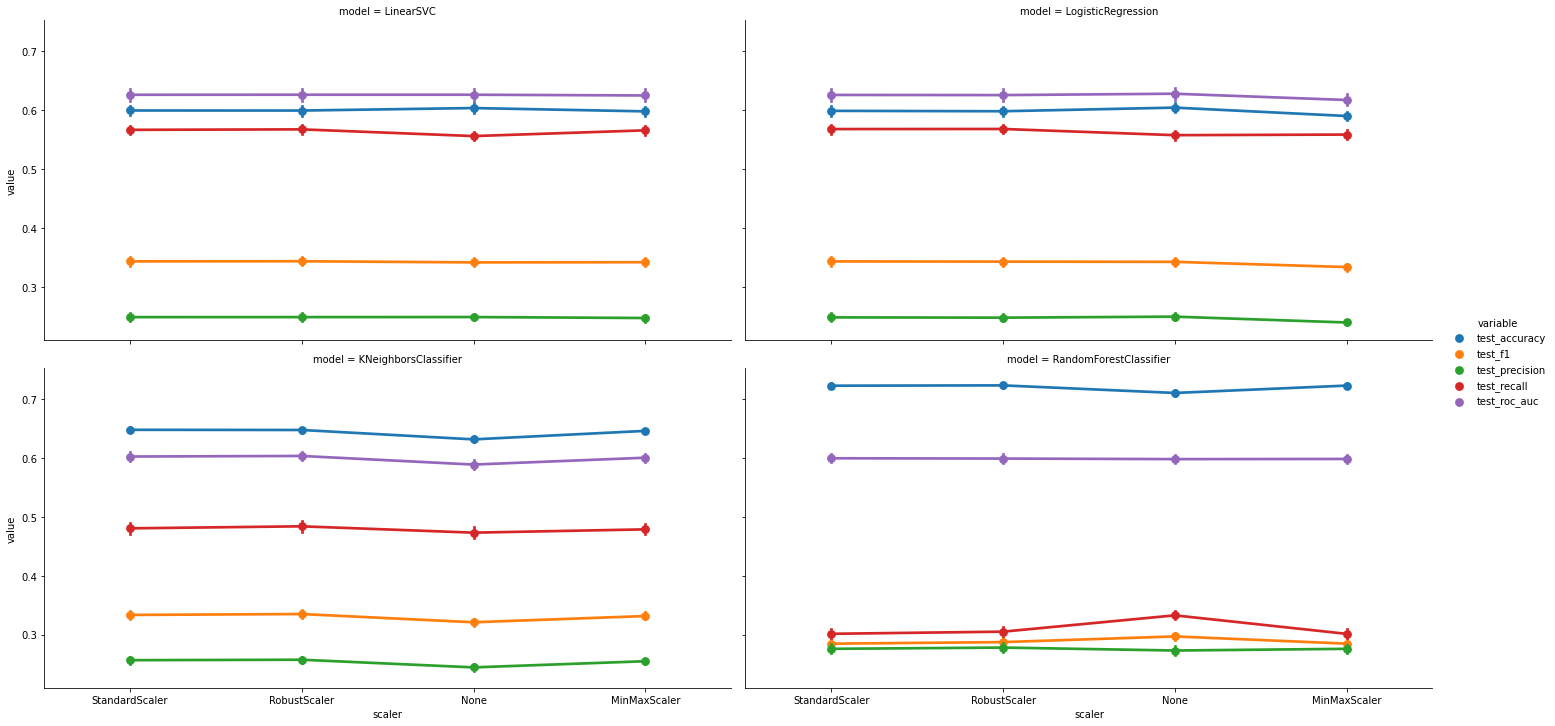

In [21]:
sns.catplot(kind='point', data=melt, x='scaler', y='value', hue='variable', col='model', col_wrap=2, height=5, aspect=2)

In [22]:
scores_data.groupby(['model','scaler']).describe()

test_accuracy                      \
                                              count      mean       std   
model                  scaler                                             
KNeighborsClassifier   MinMaxScaler           214.0  0.645801  0.031115   
                       None                   214.0  0.631391  0.039235   
                       RobustScaler           214.0  0.647316  0.032814   
                       StandardScaler         214.0  0.647613  0.032116   
LinearSVC              MinMaxScaler           214.0  0.597714  0.058914   
                       None                   214.0  0.603347  0.058319   
                       RobustScaler           214.0  0.599110  0.060280   
                       StandardScaler         214.0  0.599223  0.060428   
LogisticRegression     MinMaxScaler           214.0  0.589852  0.051291   
                       None                   214.0  0.604067  0.058023   
                       RobustScaler           214.0  0.597929  0.058477   
                       StandardScaler         214.0  0.598592  0.059307   
RandomForestClassifier MinMaxScaler           214.0  0.722626  0.035167   
                       None                   214.0  0.710141  0.038688   
                       RobustScaler           214.0  0.722986  0.034423   
                       StandardScaler         214.0  0.722468  0.035568   

                                                                               \
                                            min       25%       50%       75%   
model                  scaler                                                   
KNeighborsClassifier   MinMaxScaler    0.536486  0.628378  0.648649  0.667568   
                       None            0.533784  0.594595  0.637838  0.668581   
                       RobustScaler    0.543243  0.625676  0.650000  0.672635   
                       StandardScaler  0.540541  0.627027  0.650000  0.670270   
LinearSVC              MinMaxScaler    0.462162  0.561149  0.593919  0.636486   
                       None            0.454054  0.570608  0.597297  0.639189   
                       RobustScaler    0.458108  0.559797  0.593919  0.639189   
                       StandardScaler  0.455405  0.562500  0.594595  0.640541   
LogisticRegression     MinMaxScaler    0.459459  0.558446  0.591892  0.632432   
                       None            0.451351  0.575676  0.600000  0.641216   
                       RobustScaler    0.458108  0.559797  0.594595  0.635811   
                       StandardScaler  0.456757  0.562162  0.595270  0.636824   
RandomForestClassifier MinMaxScaler    0.612162  0.706757  0.728378  0.747297   
                       None            0.541892  0.685811  0.716892  0.739189   
                       RobustScaler    0.614865  0.704392  0.728378  0.747297   
                       StandardScaler  0.620270  0.703041  0.728378  0.747297   

                                                test_f1            ...  \
                                            max   count      mean  ...   
model                  scaler                                      ...   
KNeighborsClassifier   MinMaxScaler    0.712162   214.0  0.331638  ...   
                       None            0.681081   214.0  0.321071  ...   
                       RobustScaler    0.710811   214.0  0.335004  ...   
                       StandardScaler  0.713514   214.0  0.333527  ...   
LinearSVC              MinMaxScaler    0.713514   214.0  0.341757  ...   
                       None            0.717568   214.0  0.341464  ...   
                       RobustScaler    0.720270   214.0  0.343407  ...   
                       StandardScaler  0.721622   214.0  0.343194  ...   
LogisticRegression     MinMaxScaler    0.682432   214.0  0.333524  ...   
                       None            0.718919   214.0  0.342408  ...   
                       RobustScaler    0.718919   214.0  0.342769  ...   
                       StandardScale

It is noticeable that rescaling the data didn't change the results. Thus, no rescaling will be applied to the final models.    
<a id='finding'></a>
### Finding the best subset

In [23]:
scores_data = scores_data.query('scaler == "None"')
scores_data.groupby('model').head(1)

,test_accuracy,test_f1,test_precision,test_recall,test_roc_auc,model,scaler,qvina,rfscore_qvina,plants,rfscore_plants,Volume,Rotatable Bonds,TPSA,Molecular Weight,XLogP
1792,0.716216,0.454567,0.353758,0.647619,0.756714,LogisticRegression,None,1,0,0,0,1,1,1,1,1
1804,0.716216,0.453202,0.353611,0.640212,0.753383,LinearSVC,None,1,0,0,0,1,1,1,1,1
2612,0.764865,0.403517,0.386065,0.426455,0.691908,RandomForestClassifier,None,0,0,1,0,1,0,1,1,0
3416,0.679730,0.398518,0.306781,0.573545,0.660389,KNeighborsClassifier,None,0,0,1,1,1,1,1,1,1


<AxesSubplot:xlabel='variable', ylabel='value'>

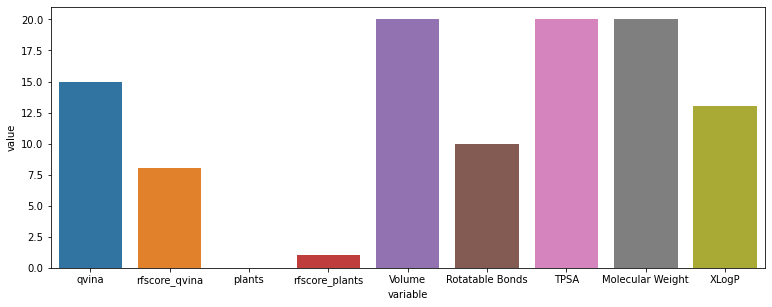

In [24]:
subset = ['qvina','rfscore_qvina','plants','rfscore_plants',
          'Volume','Rotatable Bonds','TPSA','Molecular Weight','XLogP']
n_occurrences = dict.fromkeys(subset, [0])

# How frequently does each descriptor appear in the top 20 scores?
for i, row in scores_data.iloc[:20].iterrows():
    for descriptor in subset:
        n_occurrences.update({descriptor: [n_occurrences[descriptor][0] + row[descriptor]]})

top_set = pd.melt(pd.DataFrame(n_occurrences), value_vars=n_occurrences.keys())
fig, ax = plt.subplots(figsize=(12.8, 4.8))
sns.barplot(x=top_set['variable'], y=top_set['value'], ax=ax)

In [25]:
# combinação iterada
scores_data.query('Volume == 1')

,test_accuracy,test_f1,test_precision,test_recall,test_roc_auc,model,scaler,qvina,rfscore_qvina,plants,rfscore_plants,Volume,Rotatable Bonds,TPSA,Molecular Weight,XLogP
1792,0.716216,0.454567,0.353758,0.647619,0.756714,LogisticRegression,None,1,0,0,0,1,1,1,1,1
1904,0.718919,0.460615,0.359300,0.654762,0.754170,LogisticRegression,None,1,1,0,0,1,1,1,1,1
1804,0.716216,0.453202,0.353611,0.640212,0.753383,LinearSVC,None,1,0,0,0,1,1,1,1,1
1472,0.708108,0.444145,0.344103,0.632540,0.751984,LogisticRegression,None,1,0,0,0,1,1,1,1,0
1824,0.712162,0.456488,0.351794,0.654497,0.751558,LogisticRegression,None,1,1,0,0,1,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
540,0.486486,0.244001,0.168272,0.449206,0.463953,LinearSVC,None,1,0,0,0,1,0,0,0,1
2208,0.506757,0.244151,0.169966,0.441534,0.463229,LogisticRegression,None,0,0,0,1,1,0,0,0,1
2220,0.497297,0.238677,0.165504,0.434127,0.462302,LinearSVC,None,0,0,0,1,1,0,0,0,1
48,0.478378,0.241347,0.164609,0.456878,0.447703,LogisticRegression,None,0,0,0,0,1,0,0,0,1


The frequency count shows "qvina", "Volume", "Rotatable bonds", "TPSA" and "Molecular Weight" are the most recurring descriptors.     
So let us construct and cross validate Logistic Regression, Linear SVC, RF and KNN models with these descriptors, then plot their ROC curves.     
<a id='roc_curves'></a>
### ROC curves

In [26]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split

In [27]:
from sklearn.calibration import CalibratedClassifierCV

In [28]:
def get_train_test_scores(X_train, X_test, y_train, model_fitted):    
    y_pred_train = model_fitted.predict(X_train)
    y_pred_test = model_fitted.predict(X_test)

    scores = [accuracy_score(y_train, y_pred_train), # train_accuracy
              accuracy_score(y_test, y_pred_test), # test_accuracy
              f1_score(y_train, y_pred_train), # train_f1
              f1_score(y_test, y_pred_test), # test_f1
              precision_score(y_train, y_pred_train), # train_precision
              precision_score(y_test, y_pred_test), # test_precision
              recall_score(y_train, y_pred_train), # train_recall
              recall_score(y_test, y_pred_test), # test_recall
              roc_auc_score(y_train, y_pred_train), # train_roc_auc
              roc_auc_score(y_test, y_pred_test), # test_roc_auc
             ]
    
    return scores

In [29]:
# Top models' probabilities
train_data = pd.DataFrame()
test_data = pd.DataFrame()

subset = ['qvina','Volume','Rotatable Bonds','TPSA','Molecular Weight']
new_data = data.dropna(subset=subset)
y = new_data['Active']
X = new_data[subset]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=27)

# Apply SMOTE to training data and keep original test data
sm = SMOTE(random_state=27)
X_train, y_train = sm.fit_sample(X_train, y_train)

model_list = [LogisticRegression(solver='liblinear', random_state=13), 
                    CalibratedClassifierCV(LinearSVC(dual=False, random_state=13)), 
                    RandomForestClassifier(n_estimators=10, random_state=13), 
                    KNeighborsClassifier(n_neighbors=3)]
                    # LinearSVC doesn't have a "predict_proba" function, but sklearn provides 
                    # "CalibratedClassifierCV" for this purpose

# List with each top model's scores
scores_list = []

for model in model_list:
    model_fitted = model.fit(X_train, y_train)
    scores = get_train_test_scores(X_train, X_test, y_train, model_fitted)
    
    model_name = str(model)
    if 'LinearSVC' in model_name:
        model_name = 'LinearSVC'
    else:
        model_name = model_name.split('(')[0]
        
    scores_list.append([model_name, *scores])
    
    y_proba_train = model_fitted.predict_proba(X_train)
    train_data[model_name] = y_proba_train[:,1]

    y_proba_test = model_fitted.predict_proba(X_test)
    test_data[model_name] = y_proba_test[:,1]
    
    # Keep original indices
    test_data.index = X_test.index

columns = ['model','train_accuracy','test_accuracy','train_f1','test_f1','train_precision','test_precision',
           'train_recall','test_recall','train_roc_auc','test_roc_auc']
top_scores = pd.DataFrame(scores_list, columns=columns)

In [31]:
from sklearn.metrics import auc

,model,train_accuracy,test_accuracy,train_f1,test_f1,train_precision,test_precision,train_recall,test_recall,train_roc_auc,test_roc_auc
0,LogisticRegression,0.717865,0.718919,0.718784,0.469388,0.716450,0.396552,0.721133,0.575,0.717865,0.666810
1,LinearSVC,0.716776,0.718919,0.719222,0.446809,0.713062,0.388889,0.725490,0.525,0.716776,0.648707
2,RandomForestClassifier,0.994553,0.751351,0.994547,0.361111,0.995633,0.406250,0.993464,0.325,0.994553,0.596983
3,KNeighborsClassifier,0.907407,0.643243,0.913880,0.388889,0.854167,0.308824,0.982571,0.525,0.907407,0.600431


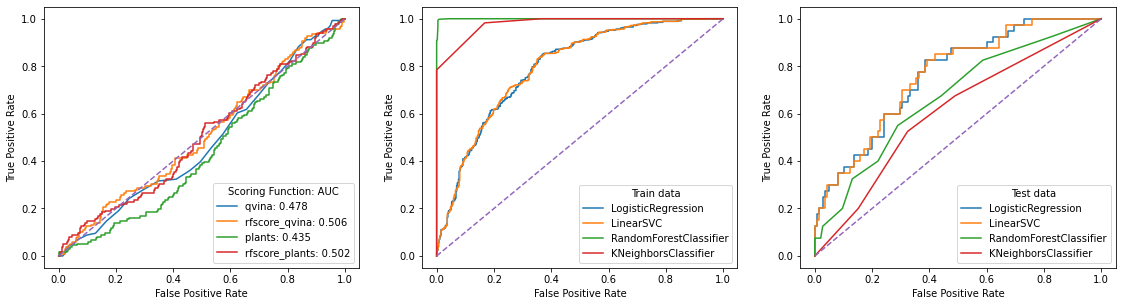

In [32]:
fig, ax = plt.subplots(ncols=3, figsize=(19.2, 4.8))

# Plot ROC curves for the docking scoring functions
for SF in ['qvina','rfscore_qvina','plants','rfscore_plants']:
    fpr, tpr, _ = roc_curve(data['Active'].values, data[SF].values)
    ax[0].plot(fpr, tpr, label=f'{SF}: {auc(fpr, tpr):>.3f}')

# Plot ROC curves for the ML models
for model_name in test_data.columns:
    fpr_train, tpr_train,_ = roc_curve(y_train, train_data[model_name])
    ax[1].plot(fpr_train, tpr_train, label=f'{model_name}')
    
    fpr_test, tpr_test,_ = roc_curve(y_test, test_data[model_name])
    ax[2].plot(fpr_test, tpr_test, label=f'{model_name}')

for i in range(3):
    # Plot a line
    ax[i].plot([0,1], [0,1], linestyle='--')
    ax[i].set_xlabel('False Positive Rate')
    ax[i].set_ylabel('True Positive Rate')

# Some legends
ax[0].legend(title='Scoring Function: AUC', loc='lower right')
ax[1].legend(title='Train data')
ax[2].legend(title='Test data')
plt.savefig('roc_auc.png')

top_scores

We can see that Logistic Regression and Linear SVC were the best models and that they yielded very similar results.         
Considering Logistic Regression is the most frequent one in the top scores, we can assume it is the most adequate model for our problem.

In [33]:
test_data['CID'] = data.loc[test_data.index]['CID']
tmp = pd.melt(test_data, id_vars=['CID'], value_vars=test_data.columns[:-1])
tmp = tmp.append(pd.melt(data.loc[test_data.index], id_vars=['CID'], value_vars=['qvina','rfscore_qvina','plants','rfscore_plants']))
df_tidy = pd.merge(data.loc[test_data.index][['CID','r_inhibition_at_50_uM']], tmp, on=['CID'])

Text(0.5, 0.98, 'Regression plots for the test set')

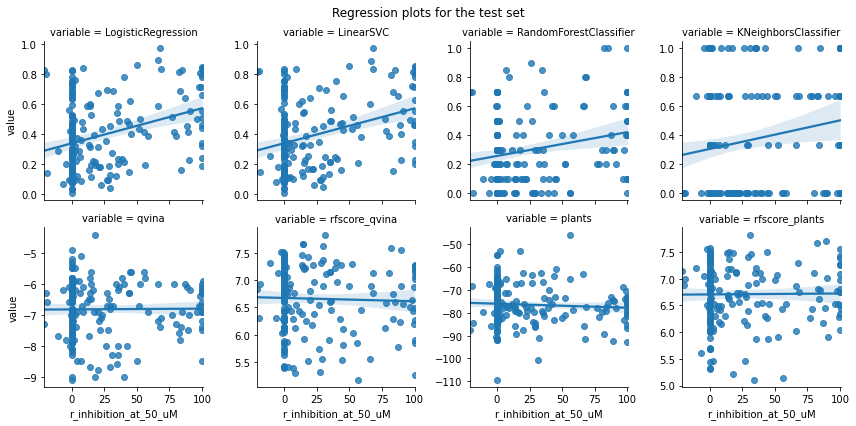

In [34]:
g = sns.FacetGrid(data=df_tidy, col='variable', col_wrap=4, sharey=False)
g.map(sns.regplot, 'r_inhibition_at_50_uM', 'value')

# Set title
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Regression plots for the test set')

In [35]:
# Pearson correlations with "r_inhibition_at_50_uM"
df_tidy.pivot_table(index=['CID','r_inhibition_at_50_uM'], columns='variable',values='value').reset_index().corr()['r_inhibition_at_50_uM']

variable
r_inhibition_at_50_uM     1.000000
KNeighborsClassifier      0.179674
LinearSVC                 0.341122
LogisticRegression        0.342813
RandomForestClassifier    0.232139
plants                   -0.069379
qvina                     0.009668
rfscore_plants            0.010812
rfscore_qvina            -0.034993
Name: r_inhibition_at_50_uM, dtype: float64

In [39]:
xgb_scores = get_mean_scores(data, 
                             train_set=['qvina','rfscore_qvina','plants','rfscore_plants','Volume','Rotatable Bonds','TPSA','Molecular Weight','XLogP'], 
                             scoring_metrics=scoring_metrics, 
                             subset=['qvina','Volume','Rotatable Bonds','TPSA','Molecular Weight','XLogP'], 
                             model=XGBRegressor(objective='reg:squarederror', random_state=13))

#pd.DataFrame([xgb_scores], columns=['fit_time','score_time','test_accuracy','test_f1','test_precision',
#         'test_recall','test_roc_auc','model','scaler','subset'])#

/home/caio/miniconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/caio/miniconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/caio/miniconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/home/caio/miniconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 504, in fit
    train_dmatrix = DMatrix(data=X, label=y, weight=sample_weight,
  File "/home/caio/miniconda3/lib/python3.8/site-packages/xgboost/core.py", line 434, in __init__
    handle, feature_names, feature_types = dispatch_data_backend(
  File "/home/caio/miniconda3/lib/python3.8/site-packages/xgboost/data.py", line 503, i

In [ ]:
# Tabela das corr
# Conjunto de teste independente
# ROC para treinamento/teste